# Introdução à Recuperação de Informações

## Lista de exercícios 2

Todos os exercícios requerem uma implementação funcional do problema, no corpo do notebook. Para cada exercício consultas de teste devem ser propostas para demonstrar que a implementação atende aos requisitos do exercício.
As resposta devem ser enviadas como um notebook (.ipynb) para o professor.

-------

**Aluno:** Franklin Alves de Oliveira

In [166]:
# imports
import os
import string
import enchant
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()  # carrega estilo do seaborn

from numpy.linalg import norm
from collections import defaultdict, Counter
from gensim import corpora, models, similarities             # gensim
from sklearn.feature_extraction.text import TfidfVectorizer  # tf-idf

# nltk
import nltk
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer as WPT
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer

**Carregando e preparando os textos de Machado de Assis...**

In [22]:
# textos de Machado de Assis
# nltk.download('machado')
texts = [machado.raw(id) for id in machado.fileids()]
print(texts[100][:443])  # trecho

Conto, A Carteira, 1884

A Carteira

Texto-fonte:

Obra Completa, de Machado de Assis,
vol. II,

Nova Aguilar, Rio de Janeiro, 1994.

Publicado originalmente em A Estação, de 15/3/1884.

... De repente, Honório olhou para
o chão e viu uma carteira. Abaixar-se, apanhá-la e guardá-la foi obra de alguns
instantes. Ninguém o viu, salvo um homem que estava à porta de uma loja, e que,
sem o conhecer, lhe disse rindo:

 Olhe, se não dá por ela;



**Tokenizando...**

In [27]:
tokenized_texts = [WPT().tokenize(t.lower()) for t in texts]
print('# de tokens no texto 100:', len(set(tokenized_texts[100])))

# de tokens no texto 100: 571


**Agora, vamos transformar esses textos tokenizados em uma coleção do nltk** (assim podemos, convenientemente, usar os métodos para esse tipo de objeto)

In [41]:
text_collection = nltk.TextCollection(tokenized_texts)

**Antes de continuar, vamos criar um vocabulário de palavras únicas nos textos...**

In [40]:
vocabulary = set([])
for t in tokenized_texts:
    vocabulary = vocabulary.union(set(t))  # adicionando palavras únicas
vocabulary = list(map(lambda x:x.lower(), vocabulary)) # passando todas as palavras para letra minúscula
vocabulary[:5]  # amostra

['segeiro', 'devaneio', 'amarra', 'seringar', 'gozlans']

### Exercício 1: Similaridade por Cosseno.

Com base na metodologia apresentada na Prática 2, usando o corpus de Machado, Construa vetorizações, binárias, por frequência e por tf-idf. Compare a ordenação dos resultados para uma consulta qualquer, com pelo menos 3 palavras. Para a ordenação dos resultados, use o cosseno entre os vetores da consulta e dos documentos.

<font color='red'>**Resposta:**</font>

Sabemos que a similaridade entre dois vetores é dada pelo cosseno do ângulo formado por eles, i.e., 

$$\text{Similarity}~(U,V) = \cos(\theta) = {\mathbf{U} \cdot \mathbf{V} \over \|\mathbf{U}\| \|\mathbf{V}\|} = \frac{ \sum_{i=1}^{n}{u_i  \cdot v_i} }{ \sqrt{\sum_{i=1}^{n}u_i^2}  \sqrt{\sum_{i=1}^{n} v_i^2} }$$

Assim, vamos resolver esse exercício da seguinte forma:

1. Criando uma consulta

In [113]:
# criando uma consulta
c = 'traição capistrano serená'
ct = WPT().tokenize(c.lower())

2. Calculando frequências sobre a consulta

In [114]:
### Criando matrizes para armazenar as frequências
binary_matrix = np.zeros((len(tokenized_texts),len(ct)))   # Frequência binária
tf_matrix = np.zeros((len(tokenized_texts),len(ct)))       # Frequência no texto
tfidf_matrix = np.zeros((len(tokenized_texts),len(ct)))    # Frequência por tf_idf

for k, word in enumerate(ct):
    for j, text in enumerate(tokenized_texts):
        tfidf_matrix[j,k] = text_collection.tf_idf(word,text)
        tf_matrix[j,k] = text_collection.tf(word,text)
        if tf_matrix[j,k] > 0:
            binary_matrix[j,k] = 1

In [115]:
# normalizando matrizes
binary_matrix_norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in binary_matrix])
tf_matrix_norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tf_matrix])
tfidf_matrix_norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tfidf_matrix])

3. criando vetores de consulta ordenados

In [116]:
# ordenando vetores
def prod(u,M):
    ''' Ordena os valores em um vetor 
    Arguments:
            - u: vector
            - M: Matrix
    Output:
            list of internal products of u with M column vectors
    '''
    return [np.dot(u,v) for v in M]

In [117]:
### Construção dos vetores ordenados
# binário
bin_vector = np.ones(len(ct))                   # cria vetor de 1's
bin_vector /= norm(bin_vector)                  # normaliza
ans_bin = prod(bin_vector, binary_matrix_norm)  # produto interno

# tf
tf_vector = np.array([text_collection.tf(w,ct) for w in ct])  # calcula a frequência dos termos
tf_vector /= norm(tf_vector)                                  # normaliza o vetor de freq.
ans_tf = prod(tf_vector, tf_matrix_norm)                      # calcula o produto interno com a matriz

# tf-idf
tfidf_vector = np.array([text_collection.tf_idf(w,ct) for w in ct])  # calcula o tf-idf
tfidf_vector /= norm(tfidf_vector)                                   # normaliza o vetor
ans_tfidf = prod(tfidf_vector,tfidf_matrix_norm)                     # calcula o produto interno

### eliminando coordenadas esparsas
vbin = filter(lambda x : x[0]!=0.0, zip(ans_bin,range(len(tokenized_texts))))
vtf = filter(lambda x : x[0]!=0.0, zip(ans_tf,range(len(tokenized_texts))))
vtfidf = filter(lambda x : x[0]!=0.0, zip(ans_tfidf,range(len(tokenized_texts))))

### ordenando os vetores por grau de similaridade
vbin = sorted(vbin, reverse=True)
vtf = sorted(vtf, reverse=True)
vtfidf = sorted(vtfidf, reverse=True) 

4. Visualizando os vetores **binários**

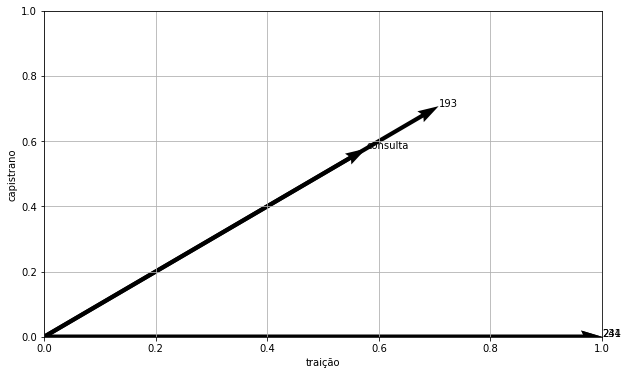

In [119]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [bin_vector[:2]]
for d in vbin[:docs]:
    vecs.append(binary_matrix_norm[d[1]][:2])
    x,y = binary_matrix_norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = np.zeros(docs+1), np.zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('traição')
ax.set_ylabel('capistrano')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

5. Visualizando os vetores por frequência

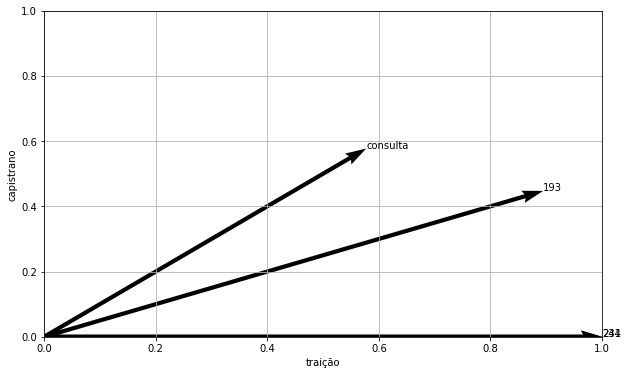

In [121]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [tf_vector[:2]]
for d in vtf[:docs]:
    vecs.append(tf_matrix_norm[d[1]][:2])
    x,y = tf_matrix_norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = np.zeros(docs+1), np.zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('traição')
ax.set_ylabel('capistrano')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

6. Visualização dos vetores por tf-idf

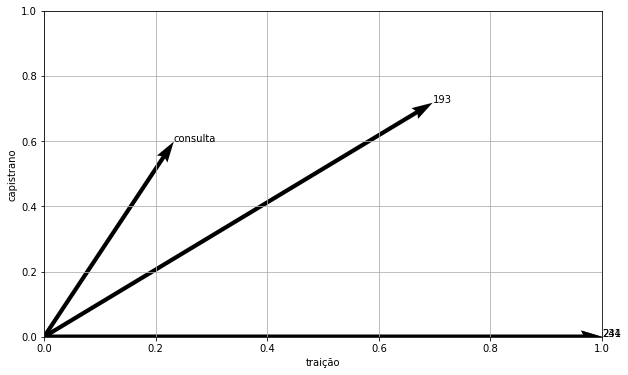

In [122]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
docs = 3
vecs = [vetor_tfidf[:2]]
for d in vtf[:docs]:
    vecs.append(tfidf_matrix_norm[d[1]][:2])
    x,y = tfidf_matrix_norm[d[1]][:2]
    plt.text(x,y,'{}'.format(d[1]))
U, V = zip(*vecs)
x,y = np.zeros(docs+1), np.zeros(docs+1)
plt.text(U[0],V[0],'consulta')
plt.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('traição')
ax.set_ylabel('capistrano')
ax.quiver(x,y,U,V,angles='xy',scale_units='xy', scale=1.0);

**Conclusão:** os resultados foram semelhantes para os três tipos de frequência.

<br>

### Exercício 2: Explorando o conceito de similaridade

Construa uma matriz de similaridade (cossenos entre vetores de frequência) entre todos os textos de machado. 
Construa um histograma com os valores de similaridade, excluindo os 0s e 1s. Interprete. 

<font color='red'>**Resposta:**</font>

Nesse exercício, vamos comparar como a frequência das palavras se diferencia entre os três tipos de "contagem". 

In [128]:
tfidf = TfidfVectorizer(min_df=1).fit_transform(texts)
matrix = (tfidf * tfidf.T).A
matrix

array([[1.        , 0.81896149, 0.83046457, ..., 0.29386488, 0.65654999,
        0.58979922],
       [0.81896149, 1.        , 0.84636708, ..., 0.2857949 , 0.66699573,
        0.59418853],
       [0.83046457, 0.84636708, 1.        , ..., 0.28538606, 0.70631686,
        0.6081249 ],
       ...,
       [0.29386488, 0.2857949 , 0.28538606, ..., 1.        , 0.21823833,
        0.21724236],
       [0.65654999, 0.66699573, 0.70631686, ..., 0.21823833, 1.        ,
        0.49688348],
       [0.58979922, 0.59418853, 0.6081249 , ..., 0.21724236, 0.49688348,
        1.        ]])

In [159]:
print(matrix.shape)

(246, 246)


Text(0, 0.5, 'Frequência')

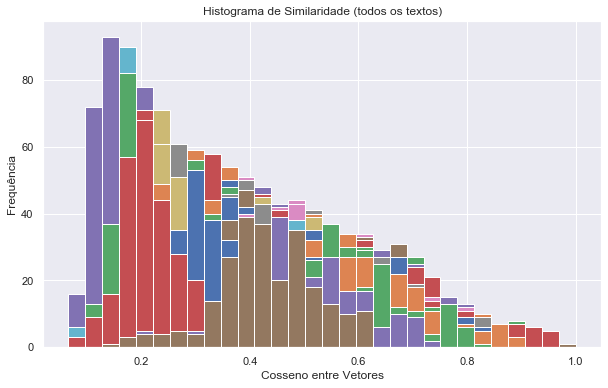

In [160]:
pd.DataFrame(matrix).plot(kind='hist', legend=False, bins=30, figsize=(10,6))          
plt.title("Histograma de Similaridade (todos os textos)")
plt.xlabel("Cosseno entre Vetores")
plt.ylabel("Frequência")

Não sei como interpretar esse gráfico (além de dizer que as distribuições são diferentes - algumas são mais assimétricas à direita)... Fiquei na dúvida se era para fazer um histograma diferente para cada texto (246 gráficos diferentes), ou se era para "empilhar" todos como fiz acima.

### Exercício 3: Usando o Gensim
Instale o Gensim, se ainda não o tiver. Seguindo o início deste tutorial: https://radimrehurek.com/gensim/tut2.html, construa um corpus usando as classes do Gensim, mas com os textos de Machado.


<font color='red'>**Resposta:**</font>



In [161]:
# coletando stopwords + pontuação (caracteres especiais)
swu = stopwords.words('portuguese')+ list(string.punctuation)

In [164]:
# instanciando o stemmer de palavras em português
Stemmer = PortugueseStemmer()

Para construir o corpus, vamos tokenizar, remover stopwords e "stemizar" os termos.

In [170]:
textos_limpos = []
c = Counter([])
for texto in textos:
    texto_limpo = [Stemmer.stem(token.strip(string.punctuation).lower()) for token in WPT().tokenize(texto) 
                                                                                       if token not in swu]
    c.update(texto_limpo)
    textos_limpos.append(texto_limpo)
textos_limpos = [[token for token in t if c[token]>1] for t in textos_limpos]

Vamos criar um ID para cada token.

In [171]:
dic = corpora.Dictionary(textos_limpos)
dic.save('vocabulario.dict')
print(dic)

Dictionary(18033 unique tokens: ['', '10', '11', '15', '186']...)


Agora, vamos criar um "corpus" que associa o ID de cada token/palavra com sua frequência nos textos.

In [173]:
corpus = [dic.doc2bow(d) for d in textos_limpos]
corpora.MmCorpus.serialize('machado.mm', corpus)

In [175]:
corpus[0][:5]  # (id, freq)

[(0, 423), (1, 1), (2, 1), (3, 1), (4, 2)]

### Exercício 4: Indexação Semântica Latente.

Ainda seguindo  o tutorial citado no exercício anterior, ajuste um modelo LSI para os documentos de machado. Interprete os resultados.

<font color='red'>**Resposta:**</font>

In [177]:
# modelo TF-IDF
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

In [179]:
# modelo LSI
lsi_model = models.LsiModel(corpus_tfidf, id2word=dic, num_topics=300)
corpus_lsi = lsi_model[corpus_tfidf]

Quanto os 15 primeiros tópicos caracterizam o "assunto" do primeiro texto do corpus.

In [181]:
corpus_lsi[0][:15]

[(0, 0.3596113784766927),
 (1, 0.23767862088702946),
 (2, 0.1947506030522646),
 (3, -0.009978592385491111),
 (4, 0.072954612864257),
 (5, -0.15044692856726816),
 (6, 0.017103453478745742),
 (7, 0.23832400184736677),
 (8, -0.16466105825322228),
 (9, 0.06661538679213803),
 (10, -0.1619564895105473),
 (11, 0.0019638579523943143),
 (12, -0.04936230922493345),
 (13, 0.0024159075944397436),
 (14, -0.06679044342532335)]

In [183]:
lsi_model.print_topics(3)

[(0,
  '0.302*"\x97" + 0.109*"sr" + 0.094*"poet" + 0.085*"luís" + 0.065*"crític" + 0.065*"camil" + 0.064*"\x93" + 0.062*"vers" + 0.059*"d" + 0.059*"jos"'),
 (1,
  '0.385*"\x97" + -0.154*"sr" + -0.150*"crític" + 0.144*"luís" + -0.137*"poet" + -0.131*"dramát" + -0.120*"alenc" + 0.103*"camil" + -0.101*"autor" + -0.100*"poes"'),
 (2,
  '0.307*"luís" + -0.241*"henriquet" + 0.142*"daniel" + 0.138*"jorg" + 0.137*"marcelin" + 0.132*"tit" + 0.130*"carlot" + 0.129*"poet" + 0.128*"cecíl" + 0.127*"alves"')]

Para interpretar os resultados de maneira mais coesa, acredito que sejam necessárias limpezas adicionais. Ainda aparecem caracteres especiais, como \x.

**Fim.**